In [1]:
# Add scripts to path and fix working directory
import sys
import os
from pathlib import Path

# Change to project root (two levels up from notebook)
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import modules
from config import PATHS, HARD_FILTERS, POPULATIONS, print_config_summary
from utils import read_panel, extract_population_samples, analyze_afreq
from hard_filters import (
    filter_snp_biallelic,
    filter_maf,
    calculate_frequencies,
    apply_all_hard_filters,
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Print configuration
print_config_summary()

Working directory: /home/Plutonium/Documents/BioinfoMidterm
CONFIGURATION SUMMARY

--- HARD FILTERS (Always Applied) ---
  SNP-only:      True
  Max alleles:   2
  Min AF:        0.0016
  Min call rate: 0.95

--- SITUATIONAL FILTERS (Context-Dependent) ---
  HWE threshold: 1e-06
  HWE mode:      keep-fewhet
  LD window:     1000kb
  LD step:       1
  LD R² cutoff:  0.1
  FST top N:     1000

--- POPULATIONS ---
  Subpopulations: ('CHB', 'JPT', 'KHV')
  Num samples:    306


## Step 1: Prepare Sample List

Extract EAS subpopulation samples (CHB, JPT, KHV) from the panel file.

In [2]:
# Read panel file
panel_df = read_panel(PATHS.PANEL_FILE)
panel_df = panel_df[["sample", "pop", "super_pop"]]
print("Panel DataFrame:")
display(panel_df.head())
print(f"\nTotal samples: {len(panel_df)}")
print(f"\nPopulation counts:")
display(panel_df['pop'].value_counts())

Panel DataFrame:


,sample,pop,super_pop
0,HG00096,GBR,EUR
1,HG00097,GBR,EUR
2,HG00099,GBR,EUR
3,HG00100,GBR,EUR
4,HG00101,GBR,EUR



Total samples: 2504

Population counts:


pop
GWD    113
YRI    108
IBS    107
TSI    107
CHS    105
PUR    104
JPT    104
CHB    103
GIH    103
ITU    102
STU    102
ESN     99
CEU     99
LWK     99
FIN     99
KHV     99
PJL     96
ACB     96
CLM     94
CDX     93
GBR     91
BEB     86
PEL     85
MSL     85
MXL     64
ASW     61
Name: count, dtype: int64

In [3]:
# Extract EAS subpopulations
EAS_SUBPOPS = list(POPULATIONS.EAS_SUBPOPS)
print(f"Extracting populations: {EAS_SUBPOPS}")

eas_df, eas_samples = extract_population_samples(
    panel_df,
    EAS_SUBPOPS,
    PATHS.EAS_SAMPLES_CSV,
    PATHS.EAS_SAMPLES_LIST,
)

print(f"\nExtracted samples:")
display(eas_df['pop'].value_counts())

Extracting populations: ['CHB', 'JPT', 'KHV']
Extracted 306 samples from populations: ['CHB', 'JPT', 'KHV']

Extracted samples:


pop
JPT    104
CHB    103
KHV     99
Name: count, dtype: int64

## Step 1b: Create Unified SNP-only Biallelic VCF

Create a master VCF file containing only biallelic SNPs (no indels, no multi-allelic sites).
This file will be used as the source for all downstream analyses across notebooks.

In [ ]:
import subprocess

# Paths
input_vcf = str(PATHS.VCF_FILE)  # main_vcf.vcf.gz (unified SNP-only biallelic VCF)
output_vcf = str(Path(PATHS.VCF_FILE).parent / "main_vcf.vcf.gz")

print(f"Input VCF: {input_vcf}")
print(f"Output VCF: {output_vcf}")

# Create SNP-only biallelic VCF using bcftools
# -v snps: keep only SNPs (no indels)
# -m2 -M2: keep only biallelic sites (exactly 2 alleles)
cmd_filter = [
    "bcftools", "view",
    "-v", "snps",
    "-m2", "-M2",
    "-O", "z",
    "-o", output_vcf,
    "--threads", "8",
    input_vcf
]

print(f"\nRunning: {' '.join(cmd_filter)}")
result = subprocess.run(cmd_filter, capture_output=True, text=True)

if result.returncode != 0:
    print(f"Error: {result.stderr}")
else:
    print("✓ SNP-only biallelic VCF created successfully")

# Create tabix index
cmd_index = ["bcftools", "index", "-t", output_vcf]
print(f"\nIndexing: {' '.join(cmd_index)}")
result_idx = subprocess.run(cmd_index, capture_output=True, text=True)

if result_idx.returncode != 0:
    print(f"Error: {result_idx.stderr}")
else:
    print("✓ Index created successfully")

# Count variants
cmd_count = ["bcftools", "view", "-H", output_vcf]
result_count = subprocess.run(cmd_count, capture_output=True, text=True)
n_variants = len(result_count.stdout.strip().split('\n')) if result_count.stdout.strip() else 0
print(f"\n✓ Total biallelic SNPs: {n_variants:,}")

Input VCF: 1000genomes/main_vcf/ALL_merged.vcf.gz
Output VCF: 1000genomes/main_vcf/main_vcf.vcf.gz

Running: bcftools view -v snps -m2 -M2 -O z -o 1000genomes/main_vcf/main_vcf.vcf.gz --threads 8 1000genomes/main_vcf/ALL_merged.vcf.gz


## Step 2: Apply SNP-only and Biallelic Filter

**HARD FILTER 1**: Keep only single nucleotide polymorphisms with at most 2 alleles.

In [ ]:
# Apply SNP-only + biallelic filter using the unified VCF
step1_output = filter_snp_biallelic(
    input_vcf=output_vcf,  # Use the unified SNP-only biallelic VCF from Step 1b
    output_pfile=str(PATHS.PLINK_SNP_FILTERED),
    keep_samples=str(PATHS.EAS_SAMPLES_LIST),
    verbose=True,
)

HARD FILTER 1: SNP-only and Biallelic
  SNP-only: True
  Max alleles: 2
  Sample filter: 1000genomes/EAS_subpopulation_samples_list.csv
Running: plink2 --threads 8 --vcf 1000genomes/main_vcf/ALL_merged.vcf.gz --snps-only --max-alleles 2 --keep 1000genomes/EAS_subpopulation_samples_list.csv --make-pgen --out 1000genomes/output/EAS_AND_SNP_filtered_data
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output/EAS_AND_SNP_filtered_data.log.
Options in effect:
  --keep 1000genomes/EAS_subpopulation_samples_list.csv
  --make-pgen
  --max-alleles 2
  --out 1000genomes/output/EAS_AND_SNP_filtered_data
  --snps-only
  --threads 8
  --vcf 1000genomes/main_vcf/ALL_merged.vcf.gz

Start time: Wed Jan 14 14:19:36 2026
15686 MiB RAM detected, ~7744 available; reserving 7680 MiB for main workspace.
Using up to 8 compute threads.
--vcf: 81271745 variants scanned.
--vcf: 10

In [10]:
# Calculate frequency statistics after Step 1
freq_prefix = calculate_frequencies(
    step1_output,
    output_prefix=f"{step1_output}_info",
)

Calculating frequency statistics: 1000genomes/output/EAS_AND_SNP_filtered_data_info.afreq
Running: plink2 --threads 8 --pfile 1000genomes/output/EAS_AND_SNP_filtered_data --freq --out 1000genomes/output/EAS_AND_SNP_filtered_data_info
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output/EAS_AND_SNP_filtered_data_info.log.
Options in effect:
  --freq
  --out 1000genomes/output/EAS_AND_SNP_filtered_data_info
  --pfile 1000genomes/output/EAS_AND_SNP_filtered_data
  --threads 8

Start time: Wed Jan 14 14:32:03 2026
15686 MiB RAM detected, ~7642 available; reserving 7578 MiB for main workspace.
Using up to 8 compute threads.
306 samples (0 females, 0 males, 306 ambiguous; 306 founders) loaded from
1000genomes/output/EAS_AND_SNP_filtered_data.psam.
77818345 variants loaded from
1000genomes/output/EAS_AND_SNP_filtered_data.pvar.
Note: No phenotype data present.

In [11]:
# Analyze frequency statistics
afreq_file = f"{freq_prefix}.afreq"
df_freq, qc_summary = analyze_afreq(
    afreq_file,
    num_samples=POPULATIONS.NUM_SAMPLES,
    maf_threshold=0.01,
    cr_threshold=0.95,
)

Loading data: 1000genomes/output/EAS_AND_SNP_filtered_data_info.afreq
Loaded 77818345 variants.
   ALT_FREQS  OBS_CT       MAF  CALL_RATE
0   0.000000     612  0.000000        1.0
1   0.000000     612  0.000000        1.0
2   0.000000     612  0.000000        1.0
3   0.000000     612  0.000000        1.0
4   0.001634     612  0.001634        1.0

--- QC Summary ---
Variants failing MAF < 0.01: 70245573 (90.27%)
Variants failing Call Rate < 0.95: 0 (0.00%)


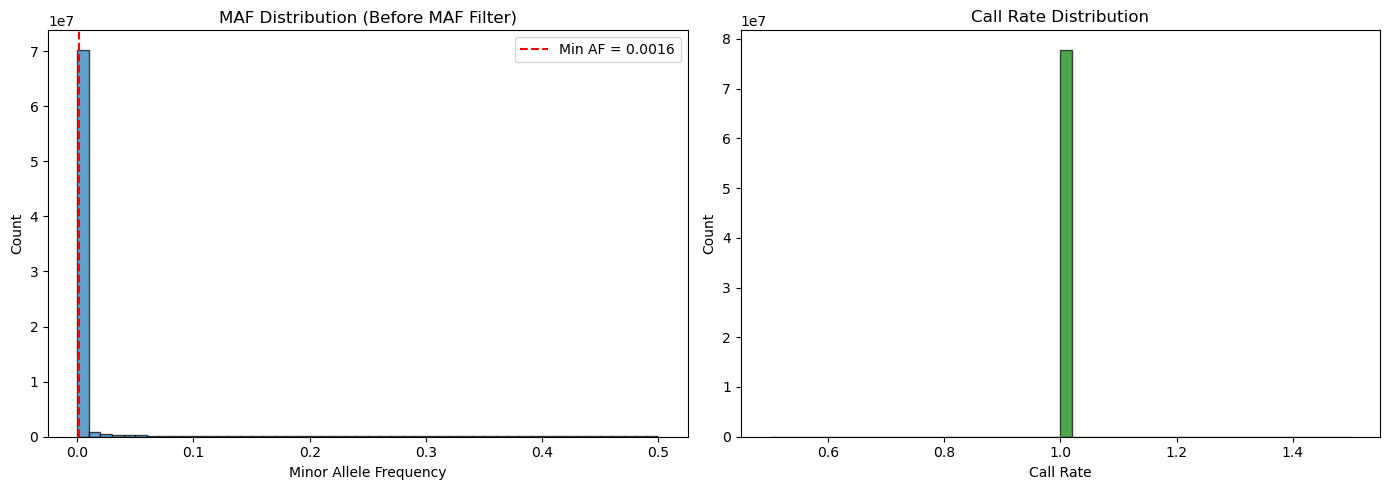


Note: Call rate is 100% for 1000 Genomes data (no missing genotypes)


In [12]:
# Visualize MAF distribution BEFORE MAF filter
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAF histogram
axes[0].hist(df_freq['MAF'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(HARD_FILTERS.MIN_AF, color='red', linestyle='--', label=f'Min AF = {HARD_FILTERS.MIN_AF}')
axes[0].set_xlabel('Minor Allele Frequency')
axes[0].set_ylabel('Count')
axes[0].set_title('MAF Distribution (Before MAF Filter)')
axes[0].legend()

# Call rate histogram
axes[1].hist(df_freq['CALL_RATE'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Call Rate')
axes[1].set_ylabel('Count')
axes[1].set_title('Call Rate Distribution')

plt.tight_layout()
plt.show()

print(f"\nNote: Call rate is 100% for 1000 Genomes data (no missing genotypes)")

## Step 3: Apply MAF Filter

**HARD FILTER 2**: Remove variants with very low allele frequency.

Threshold: 1/612 = 0.0016 (at least 1 allele in 306 diploid samples)

In [13]:
# Apply MAF filter
step2_output = filter_maf(
    input_pfile=step1_output,
    output_pfile=str(PATHS.PLINK_MAF_FILTERED),
    min_af=HARD_FILTERS.MIN_AF,
    verbose=True,
)

HARD FILTER 2: Minor Allele Frequency (MAF)
  Min AF threshold: 0.0016
  Input variants: 77818345
Running: plink2 --threads 8 --pfile 1000genomes/output/EAS_AND_SNP_filtered_data --min-af 0.0016 --make-pgen --out 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered.log.
Options in effect:
  --maf 0.0016
  --make-pgen
  --out 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered
  --pfile 1000genomes/output/EAS_AND_SNP_filtered_data
  --threads 8

Start time: Wed Jan 14 14:34:01 2026
15686 MiB RAM detected, ~5976 available; reserving 5912 MiB for main workspace.
Using up to 8 compute threads.
306 samples (0 females, 0 males, 306 ambiguous; 306 founders) loaded from
1000genomes/output/EAS_AND_SNP_filtered_data.psam.
77818345 variants loaded from
1000genome

In [14]:
# Calculate frequency statistics after MAF filter
freq_prefix_maf = calculate_frequencies(
    step2_output,
    output_prefix=f"{step2_output}_info",
)

Calculating frequency statistics: 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered_info.afreq
Running: plink2 --threads 8 --pfile 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered --freq --out 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered_info
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered_info.log.
Options in effect:
  --freq
  --out 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered_info
  --pfile 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered
  --threads 8

Start time: Wed Jan 14 14:35:40 2026
15686 MiB RAM detected, ~6167 available; reserving 6103 MiB for main workspace.
Using up to 8 compute threads.
306 samples (0 females, 0 males, 306 ambiguous; 306 founders) loaded from
1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered.psam.
17940095 variants load

In [15]:
# Analyze frequency statistics after MAF filter
afreq_file_maf = f"{freq_prefix_maf}.afreq"
df_freq_maf, qc_summary_maf = analyze_afreq(
    afreq_file_maf,
    num_samples=POPULATIONS.NUM_SAMPLES,
    maf_threshold=0.01,
    cr_threshold=0.95,
)

Loading data: 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered_info.afreq
Loaded 17940095 variants.
   ALT_FREQS  OBS_CT       MAF  CALL_RATE
0   0.001634     612  0.001634        1.0
1   0.004902     612  0.004902        1.0
2   0.022876     612  0.022876        1.0
3   0.022876     612  0.022876        1.0
4   0.003268     612  0.003268        1.0

--- QC Summary ---
Variants failing MAF < 0.01: 10367323 (57.79%)
Variants failing Call Rate < 0.95: 0 (0.00%)


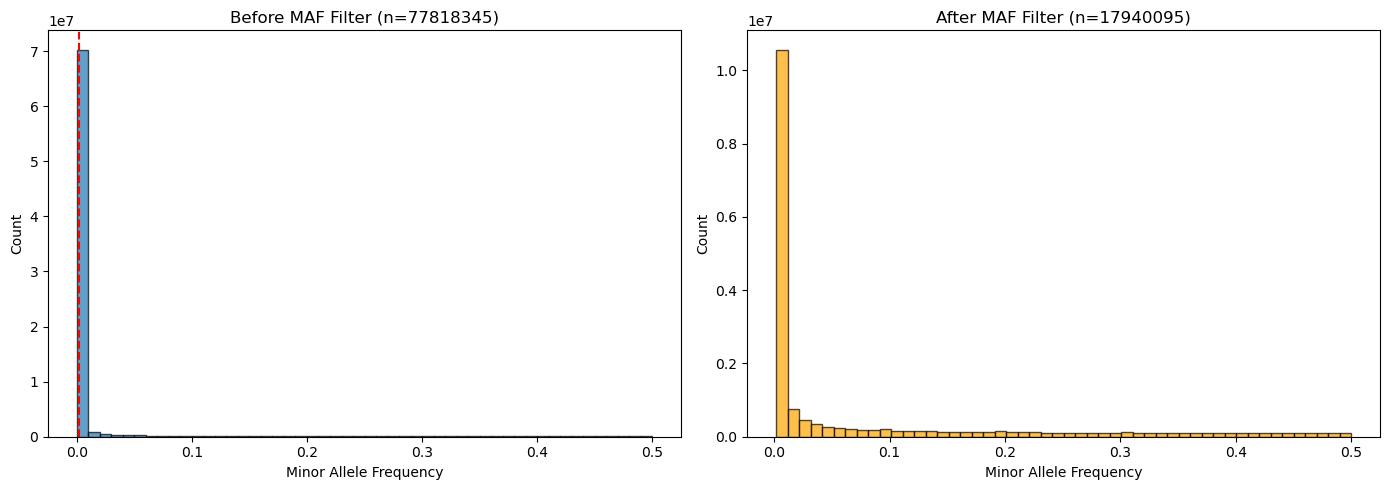

In [16]:
# Compare before and after MAF filter
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before MAF filter
axes[0].hist(df_freq['MAF'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(HARD_FILTERS.MIN_AF, color='red', linestyle='--')
axes[0].set_xlabel('Minor Allele Frequency')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Before MAF Filter (n={len(df_freq)})')

# After MAF filter
axes[1].hist(df_freq_maf['MAF'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Minor Allele Frequency')
axes[1].set_ylabel('Count')
axes[1].set_title(f'After MAF Filter (n={len(df_freq_maf)})')

plt.tight_layout()
plt.show()

## Summary

Hard filtering complete. The output can now be passed to situational filters.

In [17]:
print("="*60)
print("HARD FILTERING SUMMARY")
print("="*60)
print(f"\nFilters applied:")
print(f"  1. SNP-only: Yes")
print(f"  2. Biallelic (max 2 alleles): Yes")
print(f"  3. Sample subsetting: {EAS_SUBPOPS}")
print(f"  4. MAF >= {HARD_FILTERS.MIN_AF}")
print(f"\nVariant counts:")
print(f"  After SNP/biallelic: {len(df_freq)}")
print(f"  After MAF filter: {len(df_freq_maf)}")
print(f"  Removed by MAF: {len(df_freq) - len(df_freq_maf)} ({(len(df_freq) - len(df_freq_maf))/len(df_freq)*100:.2f}%)")
print(f"\nOutput file: {step2_output}")
print(f"\nNext step: Run 02_situational_filtering.ipynb")

HARD FILTERING SUMMARY

Filters applied:
  1. SNP-only: Yes
  2. Biallelic (max 2 alleles): Yes
  3. Sample subsetting: ['CHB', 'JPT', 'KHV']
  4. MAF >= 0.0016

Variant counts:
  After SNP/biallelic: 77818345
  After MAF filter: 17940095
  Removed by MAF: 59878250 (76.95%)

Output file: 1000genomes/output/EAS_AND_SNP_filtered_data_MAF_filtered

Next step: Run 02_situational_filtering.ipynb
